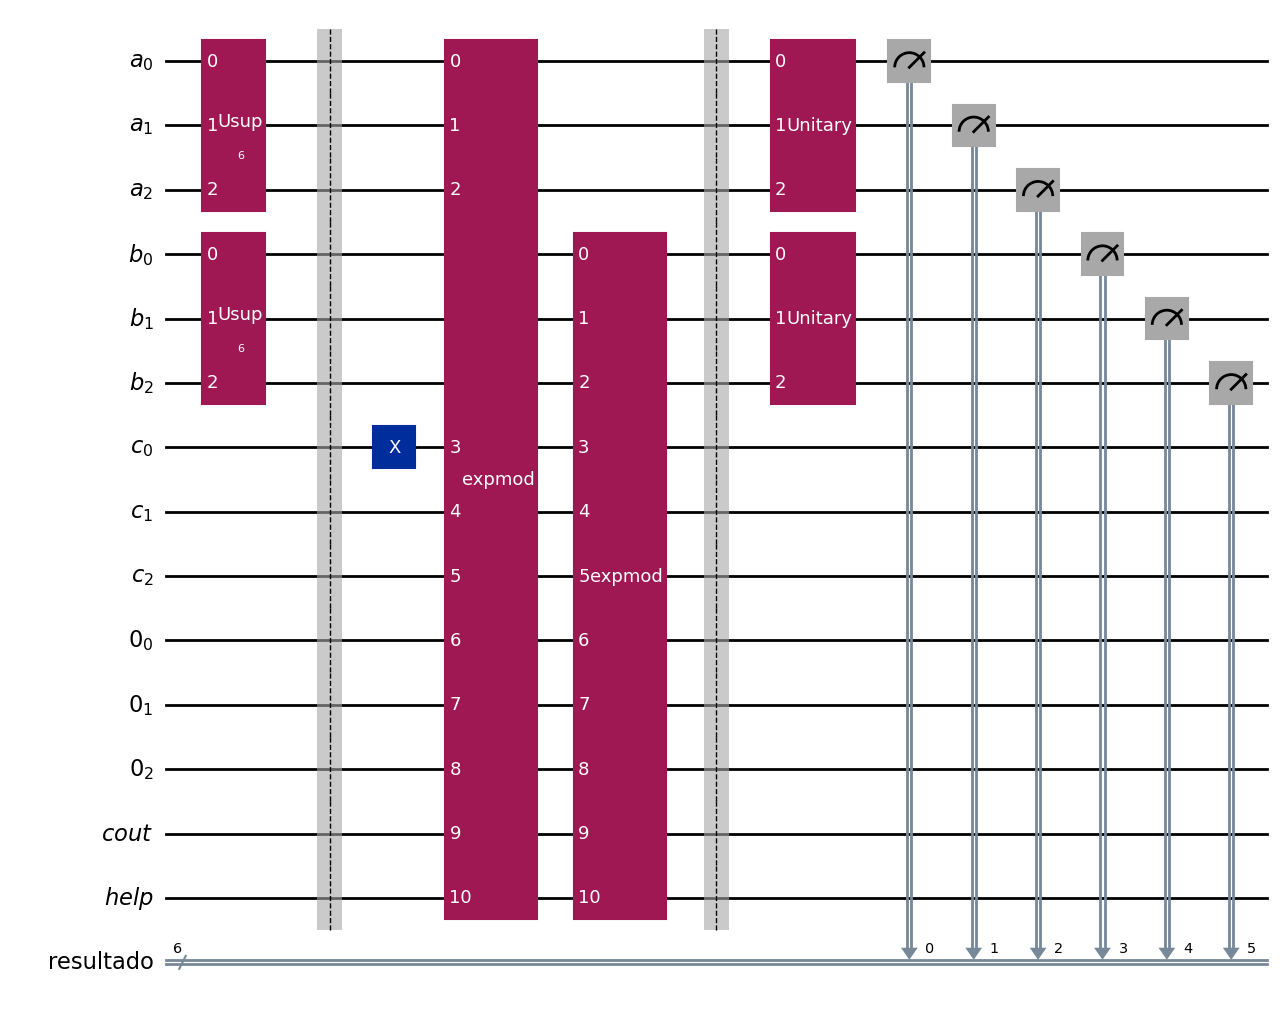

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.circuit.library.data_preparation import UniformSuperpositionGate
import numpy as np
from math import gcd, log2
from expmod import expmod

def gcdExtended(a, b): 
    if a == 0 : 
        return b,0,1
             
    gcd,x1,y1 = gcdExtended(b%a, a) 
     
    x = y1 - (b//a) * x1 
    y = x1 
     
    return gcd,x,y 

def mod_inverse(x, p):
    gcd, inv, _ = gcdExtended(x, p)
    if gcd != 1:
        raise ValueError("O inverso não existe")
    return inv % p

def qft_modf(p):
    """
    Cria o operador QFT modificado para N = p-1 (baseado no artigo)
    """
    n = p.bit_length()  # número de qubits necessários
    N = p - 1  # número de estados
    
    # matriz de transformação só com 0s
    U = np.zeros((2**n, 2**n), dtype=complex) # se o tipo não for complexo, dá erro na multiplicação
    
    for j in range(N):
        for k in range(N):
            U[j, k] = np.exp(2 * np.pi * 1j * j * k / N) / np.sqrt(N)
    
    # preenchendo o restante da matriz com 1s na diagonal
    for j in range(N, 2**n):
        U[j, j] = 1
    
    return U

def qft_no_circuito(circuito, p, reg):
    """
    Aplica o QFT modificado a um registrador específico em um circuito quântico.
    """
    U = qft_modf(p)
    
    # criando uma porta unitária com a matriz U
    qft_nova = UnitaryGate(U, label='Modified QFT').inverse()
    
    # aplicando a porta ao registrador especificado
    circuito.append(qft_nova, reg)


def discrete_log(g, x, p):
    n_bits = p.bit_length()  # Número de qubits para a e b (ordem de g)

    reg_a = QuantumRegister(n_bits, 'a')
    reg_b = QuantumRegister(n_bits, 'b')
    reg_c = QuantumRegister(n_bits, 'c')
    reg_c_aux = QuantumRegister(1, "c_aux")
    reg_0 = QuantumRegister(n_bits, "0")
    reg_cout = QuantumRegister(1, "cout")
    reg_help = QuantumRegister(1, "help")
    cl = ClassicalRegister(2*n_bits, 'resultado')
    circuito = QuantumCircuit(reg_a, reg_b, reg_c, reg_0, reg_cout, reg_help, cl)

    #superposition_state = [1/np.sqrt(p-1) if i < p-1 else 0 for i in range(2**n_bits)]
    

    # Superposição nos registradores a e b
    #circuito.initialize(superposition_state, reg_a)
    #circuito.initialize(superposition_state, reg_b)
    circuito.append(UniformSuperpositionGate(p-1, n_bits), reg_a)
    circuito.append(UniformSuperpositionGate(p-1, n_bits), reg_b)

    circuito.barrier()

    # Inicializa c em |1⟩
    circuito.x(reg_c[0])

    # Calcula g^a mod p no registrador c
    circuito.append(expmod(p, g, n_bits), reg_a[:] + reg_c[:] + reg_0[:] + reg_cout[:] + reg_help[:])    
        

    inv_x = mod_inverse(x, p)

    # Calcula h^b mod p e multiplica por c (g^a)
    circuito.append(expmod(p, inv_x, n_bits), reg_b[:] + reg_c[:] + reg_0[:] + reg_cout[:] + reg_help[:])    
    
    circuito.barrier()

    # Aplica QFT e mede a e b
    qft = QFT(n_bits, inverse=True)
    #circuito.append(qft, reg_a)
    #circuito.append(qft, reg_b)
    qft_no_circuito(circuito, p, reg_a)
    qft_no_circuito(circuito, p, reg_b)

    circuito.measure(reg_a, cl[:n_bits])
    circuito.measure(reg_b, cl[n_bits:])

    return circuito

# Exemplo: g**r = x mod p
g, x, p = 2, 4, 7
n_bits = (p-1).bit_length()
circuito = discrete_log(g, x, p)

circuito.draw("mpl")

In [2]:
from qiskit_aer import AerSimulator
from qiskit import transpile


backend1 = AerSimulator()
qc1 = transpile(circuito, backend=backend1)

from qiskit.primitives import StatevectorSampler

statevectorsampler = StatevectorSampler()
pub = (qc1)
job = statevectorsampler.run([pub], shots=8192)
print(job.result()[0].data.resultado.get_int_counts())
#print(job.result()[0].data.c_measure.get_int_counts())

counts = job.result()[0].data.resultado.get_int_counts()

l = []

for i in counts:
    res = f"{i:9b}".strip()
    resC = "0b0" + res[:-p.bit_length()]
    resD = "0b" + res[-p.bit_length():]
    l.append([(eval(resC), eval(resD)), counts[i]])
    #print("|c>:", eval(resC),"|d>:",eval(resD))

Resultado = job.result()[0].data.resultado.get_int_counts()

l.sort(key=lambda x: x[1], reverse=True)
print("[(c, d), #]")
print(l)


{0: 2798, 18: 2622, 36: 2772}
[(c, d), #]
[[(0, 0), 2798], [(4, 4), 2772], [(2, 2), 2622]]


In [3]:
def calculo_r(counts, p, g, x):
    p_menos_1 = p - 1
    for result in counts:
        # Extrai os valores de 'a' e 'b' da medição
        #res = f"{result:9b}".strip()
        #resC = "0b0" + res[:-p.bit_length()]
        #resD = "0b" + res[-p.bit_length():]
        a = result[0][0]
        b = result[0][1]
        #a = eval(resC)
        #b = eval(resD)
        print(a, b)
        # Passo 1: Simplificar c' e d' dividindo pelo GCD
        mdc = gcd(a, b)
        if mdc == 0:
            continue
        c_prime = a // mdc
        d_prime = b // mdc
        
        # Passo 2: Verificar se c' é coprimo com p-1
        if gcd(c_prime, p_menos_1) != 1:
            continue
        
        # Passo 3: Calcular o inverso de c' mod (p-1)
        try:
            c_inv = mod_inverse(c_prime, p_menos_1)
        except ValueError:
            continue  # Inverso não existe
        
        # Passo 4: Calcular r = -d' * c_inv mod (p-1)
        r_candidate = (-d_prime * c_inv) % p_menos_1
        print("Candidato r: ", r_candidate)
        
        # Verifica se o candidato satisfaz g^r ≡ x mod p
        if pow(g, r_candidate, p) == x:
            return r_candidate
    
    return None  # Nenhum r válido encontrado

# Extrai r a partir das medições
r = calculo_r(l, p, g, x)

if r:
    print(f"Logaritmo discreto encontrado: r = {r} (verificação: {g}^{r} mod {p} = {pow(g, r, p)})")
else:
    print("Nenhum r válido encontrado. Execute novamente.")

0 0
4 4
Candidato r:  5
Logaritmo discreto encontrado: r = 5 (verificação: 2^5 mod 7 = 4)


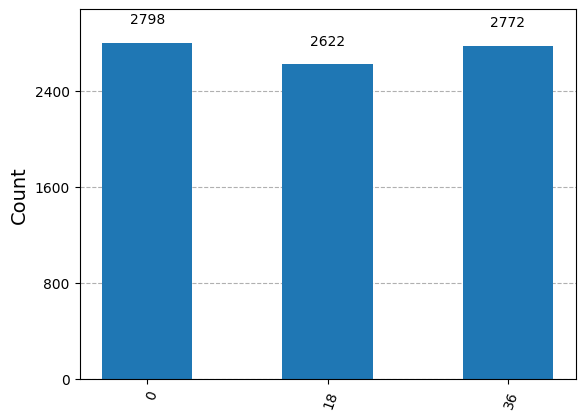

In [4]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado)

In [5]:
arq = open("disclog.txt", "w")

tabela = []
for i in range(2**n_bits):
    linha = []
    for j in range(2**n_bits):
        linha.append(0)
    tabela.append(linha)

for value in l:
    tabela[value[0][1]][value[0][0]] = value[1]

for linha in tabela:
    for v in linha:
        arq.write(str(v) + "\t")
    arq.write("\n")
    print(*linha, sep="\t")
arq.flush()

2798	0	0	0	0	0	0	0
0	0	0	0	0	0	0	0
0	0	2622	0	0	0	0	0
0	0	0	0	0	0	0	0
0	0	0	0	2772	0	0	0
0	0	0	0	0	0	0	0
0	0	0	0	0	0	0	0
0	0	0	0	0	0	0	0
